In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import os

### **Data Processing**

#### Merge Datasets

In [3]:
path = "/content/drive/MyDrive/Data Science/Data Sets/Sales Data Analysis/"

files = [file for file in os.listdir(path)]

all_sales_data = pd.DataFrame()

for file in files:
  df = pd.read_csv(path+file)
  all_sales_data = pd.concat([all_sales_data, df])

all_sales_data.to_csv("all_sales_data.csv", index= False)

#### Import Data

In [4]:
sales_df = pd.read_csv("all_sales_data.csv")
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


### **Data Cleaning**

#### Drop NAN rows

In [5]:
# Check for NAN rows
nan_df = sales_df[sales_df.isna().any(axis=1)]
# nan_df.head()

#Drop NAN rows
sales_df = sales_df.dropna(how='all')
sales_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


#### Drop Inconsistent Rows

In [ ]:
# Display rows where Order ID contains non-numeric values
sales_df.loc[(sales_df['Order ID'].str.isdigit() == False), :]

In [7]:
# Display rows where first index of 'Order Date' is not '0' or '1'
sales_df[(sales_df['Order Date'].str[0] != '0') & (sales_df['Order Date'].str[0] != '1')]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1149,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2878,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2893,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
182788,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
184468,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
184516,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
185160,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [8]:
# Drop rows
filtered_sdf = sales_df.drop(sales_df[(sales_df['Order Date'].str[0] != '0') & (sales_df['Order Date'].str[0] != '1')].index)  

#### Change Data Types

In [9]:
filtered_sdf['Order ID'] = pd.to_numeric(filtered_sdf['Order ID']) # make int
filtered_sdf['Quantity Ordered'] = pd.to_numeric(filtered_sdf['Quantity Ordered'])
filtered_sdf['Price Each'] = pd.to_numeric(filtered_sdf['Price Each']) # make float
filtered_sdf['Order Date'] = pd.to_datetime(filtered_sdf['Order Date']) # make datetime


In [10]:
filtered_sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


### **Data Transformation**

#### Add Month Column

In [11]:
filtered_sdf['Month'] = filtered_sdf['Order Date'].dt.month

#### Add Year Column

In [12]:
filtered_sdf['Year'] = filtered_sdf['Order Date'].dt.year

#### Add Year/Month Column

In [13]:
filtered_sdf['Year/Month'] = filtered_sdf['Order Date'].dt.strftime('%Y-%m')

#### Add Quarter Column

In [14]:
filtered_sdf['Quarter'] = filtered_sdf['Order Date'].dt.quarter

#### Add Weekday Column

In [15]:
# Return day of the week as an integer, where Monday is 0 and Sunday is 6

filtered_sdf['Weekday'] = filtered_sdf['Order Date'].dt.weekday

#### Add Hour Column

In [16]:
filtered_sdf['Hour'] = filtered_sdf['Order Date'].dt.hour

#### Add Sales Column

In [17]:
filtered_sdf['Sales'] = filtered_sdf['Quantity Ordered'] * filtered_sdf['Price Each']

#### Add City Column

In [18]:
# .apply()
def get_city(address):
  return address.split(',')[1]

# .apply()
def get_state(address):
  return address.split(',')[2].split(' ')[1]

filtered_sdf['City'] = filtered_sdf['Purchase Address'].apply(lambda x: get_city(x) + ' (' + get_state(x) + ')')

#### Add State Column

In [19]:
# .apply()
def get_state(address):
  return address.split(',')[2].split(' ')[1]

filtered_sdf['State'] = filtered_sdf['Purchase Address'].apply(lambda x: get_state(x))

#### Add Region Column

In [20]:
wc = ['CA', 'OR', 'WA']
cen = ['TX']
ec = ['GA', 'MA', 'ME', 'NY']

def region(x):
  if x['State'] in wc:
    reg = 'West Coast'
  elif x['State'] in cen:
    reg = 'Central'
  elif x['State'] in ec:
    reg = 'East Coast'
  return reg

filtered_sdf['Region'] = filtered_sdf.apply(region, axis=1)

### Filtered Data

In [21]:
filtered_sdf.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Year,Year/Month,Quarter,Weekday,Hour,Sales,City,State,Region
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,2019,2019-04,2,4,8,23.90,Dallas (TX),TX,Central
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,2019,2019-04,2,6,22,99.99,Boston (MA),MA,East Coast
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,2019-04,2,4,14,600.00,Los Angeles (CA),CA,West Coast
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,2019,2019-04,2,4,14,11.99,Los Angeles (CA),CA,West Coast
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,2019,2019-04,2,1,9,11.99,Los Angeles (CA),CA,West Coast


### **Data Analysis** (Business Questions)

In [22]:
pd.options.display.float_format = '{:.2f}'.format

#### **Revenue Analysis**

In [23]:
total_rev = filtered_sdf['Sales'].sum()

##### **Monthly Revenue**

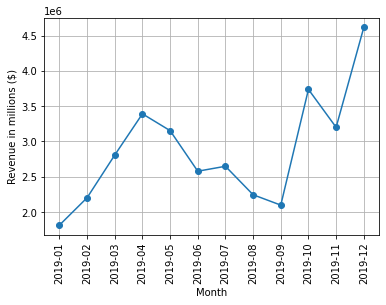

,Year/Month,Sales
0,2019-01,1813586.44
1,2019-02,2202022.42
2,2019-03,2807100.38
3,2019-04,3390670.24
4,2019-05,3152606.75
5,2019-06,2577802.26
6,2019-07,2647775.76
7,2019-08,2244467.88
8,2019-09,2097560.13
9,2019-10,3736726.88


In [24]:
month_rev = filtered_sdf.groupby('Year/Month').sum()['Sales'][:-1]
m2m = month_rev.reset_index()
months = [month for month, df in filtered_sdf.groupby('Year/Month')][:-1]
# dropped last month since incomplete

plt.plot(months, month_rev, marker='o')
plt.xticks(months, rotation=90)
plt.xlabel('Month')
plt.ylabel('Revenue in millions ($)')
plt.grid(True)
plt.show()

m2m

##### **Monthly Revenue Growth (MRG) Rate**

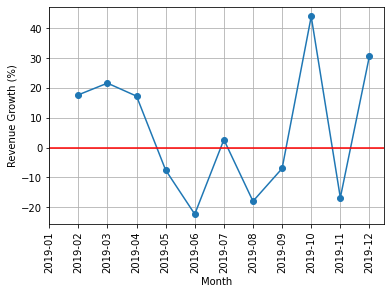

,Year/Month,Sales,MRG %
0,2019-01,1813586.44,nan
1,2019-02,2202022.42,17.64
2,2019-03,2807100.38,21.56
3,2019-04,3390670.24,17.21
4,2019-05,3152606.75,-7.55
5,2019-06,2577802.26,-22.30
6,2019-07,2647775.76,2.64
7,2019-08,2244467.88,-17.97
8,2019-09,2097560.13,-7.00
9,2019-10,3736726.88,43.87


In [25]:
m2m['MRG %'] = round((m2m['Sales'] - m2m['Sales'].shift(1))/m2m['Sales']*100, 2)
mrg = m2m['MRG %']
months = [month for month, df in filtered_sdf.groupby('Year/Month')][:-1]

plt.plot(months, mrg, marker='o')
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(months, rotation=90)
plt.xlabel('Month')
plt.ylabel('Revenue Growth (%)')
plt.grid(True)
plt.show()

m2m

##### **Which quarter had highest revenue? How much?**

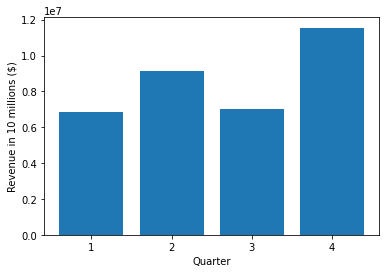

Quarter 4 @ $11,549,773.42

% of Total Revenue: 33.49%


In [26]:
quarter_sales = filtered_sdf.groupby('Quarter').sum()
quarters = range(1,5)

plt.bar(quarters, quarter_sales['Sales'])
plt.xticks(quarters)
plt.xlabel('Quarter')
plt.ylabel('Revenue in 10 millions ($)')
plt.show()

maxQ = max(quarter_sales['Sales'])
bestQ ="${:,.2f}".format(maxQ)
Q = quarter_sales[quarter_sales['Sales'] == maxQ].index.item()
Qpercent = round(maxQ/total_rev*100, 2)
print('Quarter ' + str(Q) + ' @ ' + bestQ +
      '\n\n% of Total Revenue: ' +  str(Qpercent) + '%')

##### **Which month had the highest revenue? How much?**

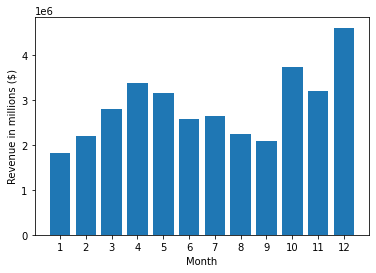

Month 12 @ $4,613,443.34

% of Total Revenue: 13.38%


In [27]:
month_sales = filtered_sdf.groupby('Month').sum()
months = range(1,13)

plt.bar(months, month_sales['Sales'])
plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Revenue in millions ($)')
plt.show()

maxM_Sales = max(month_sales['Sales'])
bestM_Sales ="${:,.2f}".format(maxM_Sales)
MS = month_sales[month_sales['Sales'] == maxM_Sales].index.item()
MSpercent = round(maxM_Sales/total_rev*100, 2)

print('Month ' + str(MS) + ' @ ' + bestM_Sales +
      '\n\n% of Total Revenue: ' +  str(MSpercent) + '%')

##### **Which day of the week had the highest revenue?**

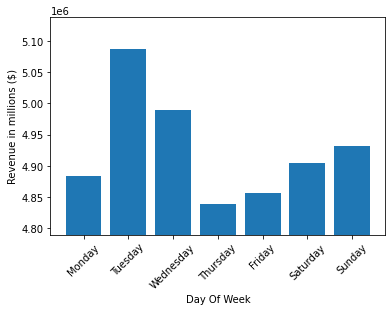

Tuesday @ $5,087,956.78

% of Total Revenue: 14.75%


In [28]:
dow_sales = filtered_sdf.groupby('Weekday').sum()
dow = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dow1 = list(dow.keys())
dow2 = list(dow.values())

plt.bar(dow1, dow_sales['Sales'])
plt.ylim(min(dow_sales['Sales'])-50000, max(dow_sales['Sales'])+50000)
plt.xticks(ticks=dow1, labels=dow2, rotation= 45)
plt.xlabel('Day Of Week')
plt.ylabel('Revenue in millions ($)')
plt.show()

max_dowSales = max(dow_sales['Sales'])
best_dowSales ="${:,.2f}".format(max_dowSales)
dowS = dow_sales[dow_sales['Sales'] == max_dowSales].index.item()
dowSpercent = round(max_dowSales/total_rev*100, 2)

print(dow[dowS] + ' @ ' + best_dowSales +
      '\n\n% of Total Revenue: ' +  str(dowSpercent) + '%')

##### **What were the 5 best days for sales?**

In [29]:
Day_Sales = filtered_sdf.groupby(filtered_sdf['Order Date'].dt.date).sum()['Sales']
Top_Five_DS = Day_Sales.sort_values(ascending=False).head().reset_index()
Top_Five_DS

,Order Date,Sales
0,2019-12-04,166727.69
1,2019-12-16,162970.61
2,2019-12-10,162832.74
3,2019-12-20,160181.30
4,2019-12-17,157364.72


##### **What US City had the highest revenue?**

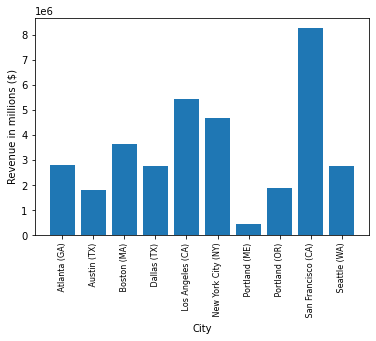

 San Francisco (CA) @ $8,262,203.91

% of Total Revenue: 23.95%


In [30]:
city_sales = filtered_sdf.groupby('City').sum()
cities = [city for city, df in filtered_sdf.groupby('City')]

plt.bar(cities, city_sales['Sales'])
plt.xticks(cities, rotation='vertical', size=8)
plt.xlabel('City')
plt.ylabel('Revenue in millions ($)')
plt.show()

max_citySales = max(city_sales['Sales'])
best_citySales ="${:,.2f}".format(max_citySales)
cityS = city_sales[city_sales['Sales'] == max_citySales].index.item()
citySpercent = round(max_citySales/total_rev*100, 2)

print(cityS + ' @ ' + best_citySales +
      '\n\n% of Total Revenue: ' +  str(citySpercent) + '%')

##### **What US State had the highest revenue?**

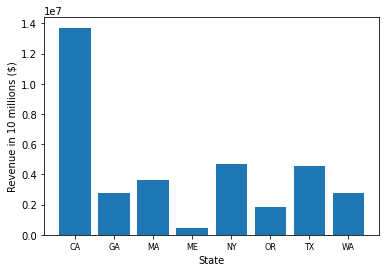

CA @ $13,714,774.71

% of Total Revenue: 39.76%


In [31]:
state_sales = filtered_sdf.groupby('State').sum()
states = [state for state, df in filtered_sdf.groupby('State')]

plt.bar(states, state_sales['Sales'])
plt.xticks(states, size=8)
plt.xlabel('State')
plt.ylabel('Revenue in 10 millions ($)')
plt.show()

max_stateSales = max(state_sales['Sales'])
best_stateSales ="${:,.2f}".format(max_stateSales)
stateS = state_sales[state_sales['Sales'] == max_stateSales].index.item()
stateSpercent = round(max_stateSales/total_rev*100, 2)

print(stateS + ' @ ' + best_stateSales +
      '\n\n% of Total Revenue: ' +  str(stateSpercent) + '%')

#### **Product Analysis**

In [32]:
total_sales = filtered_sdf['Order ID'].count()

##### **Monthly Order Count**

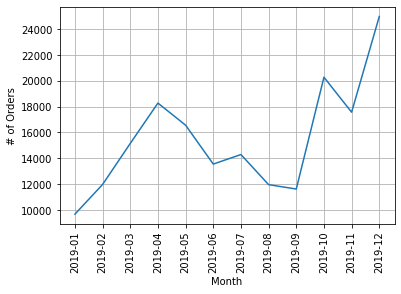

,Year/Month,Order ID
0,2019-01,9675
1,2019-02,11975
2,2019-03,15153
3,2019-04,18279
4,2019-05,16566
5,2019-06,13554
6,2019-07,14293
7,2019-08,11961
8,2019-09,11621
9,2019-10,20282


In [33]:
month_count = filtered_sdf.groupby('Year/Month').count()['Order ID'][:-1]
months = [month for month, df in filtered_sdf.groupby('Year/Month')][:-1]
# dropped '2020-01' since incomplete

plt.plot(months, month_count)
plt.xticks(months, rotation=90)
plt.xlabel('Month')
plt.ylabel('# of Orders')
plt.grid()
plt.show()

month_count.reset_index()

##### **What time should we display Ads to maximize likelihood of customer's buying products?**

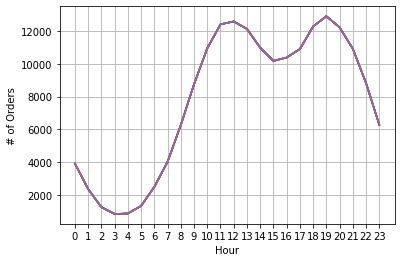

Hour of the day with most orders: 19 @ 12905 orders

% of Total Orders: 6.94%


In [34]:
total_sales = filtered_sdf['Order ID'].count()
hour_count = filtered_sdf.groupby('Hour').count()
hours = [hour for hour, df in filtered_sdf.groupby('Hour')]

plt.plot(hours, hour_count)
plt.xticks(hours)
plt.xlabel('Hour')
plt.ylabel('# of Orders')
plt.grid()
plt.show()

tophours = hour_count['Order ID'].sort_values(ascending=False).head(3).reset_index()
tophour = tophours['Hour'][0]
tophour_sales = hour_count.loc[hour_count.index == tophour, 'Order ID'].item()
thSpercent = round(tophour_sales/total_sales*100, 2)

print('Hour of the day with most orders: ' + str(tophour) + ' @ ' + str(tophour_sales) + ' orders' +
      '\n\n% of Total Orders: ' +  str(thSpercent) + '%')

##### **What products are most often sold together? (Top 10)**

In [ ]:
# Group products together by Order ID
df2 = filtered_sdf[filtered_sdf['Order ID'].duplicated(keep=False)]
df2['Grouped'] = df2.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df2 = df2[['Order ID', 'Grouped']].drop_duplicates()

In [36]:
# Use Counter() to find # of combinations (2)
from itertools import combinations
from  collections import Counter

count = Counter()

for row in df2['Grouped']:
  row_list = row.split(',')
  count.update(Counter(combinations(row_list, 2)))

# Sort and create Grouped dataframe
grouped = count.most_common()
group_order = [str(i[0]) for i in grouped]
group_order_num = [i[1] for i in grouped]
grouped_df = pd.DataFrame(list(zip(group_order, group_order_num)), columns=['Grouped Orders', 'Order Count'])
grouped_df.head()

,Grouped Orders,Order Count
0,"('iPhone', 'Lightning Charging Cable')",1005
1,"('Google Phone', 'USB-C Charging Cable')",987
2,"('iPhone', 'Wired Headphones')",447
3,"('Google Phone', 'Wired Headphones')",414
4,"('Vareebadd Phone', 'USB-C Charging Cable')",361


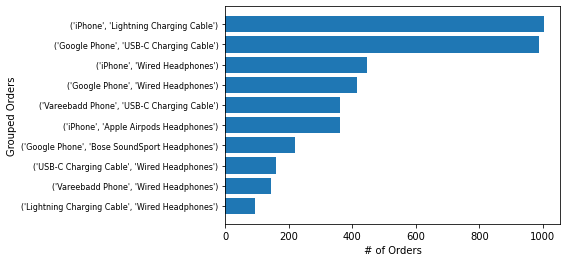

In [37]:
# Display Top 10
g_top10 = grouped_df['Grouped Orders'][:10]
gc_top10 = grouped_df['Order Count'][:10]

plt.barh(g_top10, gc_top10)
plt.yticks(g_top10, size=8)
plt.xlabel('# of Orders')
plt.ylabel('Grouped Orders')
plt.gca().invert_yaxis()
plt.show()

##### **What products sold the most? Why?**

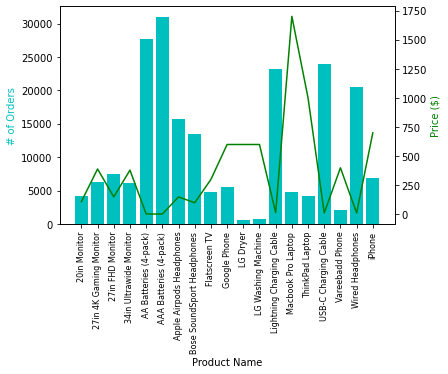


Lower prices -> higher quantity ordered


In [38]:
product_df = filtered_sdf.groupby('Product')
quantity_ordered = product_df.sum()['Quantity Ordered']
products = [product for product, df in product_df]
prices = filtered_sdf.groupby('Product').mean()['Price Each']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color='c')
ax2.plot(products, prices, color= 'g')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('# of Orders', color='c')
ax2.set_ylabel('Price ($)', color='g')
ax1.set_xticklabels(products, rotation='vertical', size=8)

plt.show()

print('\nLower prices -> higher quantity ordered')

#### **State Analysis**

##### **What is the average spend per order by State?**

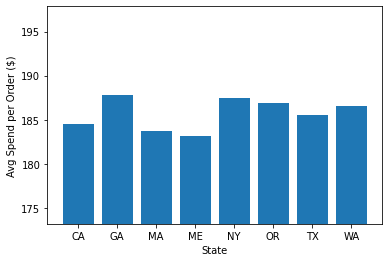

In [39]:
state_spend_df = filtered_sdf.groupby('State')
avg_state_spend = state_spend_df.mean()['Sales']
states = [state for state, df in state_spend_df]

plt.bar(states, avg_state_spend)
plt.ylim(min(avg_state_spend)-10, max(avg_state_spend)+10)
plt.xticks(states)
plt.xlabel('State')
plt.ylabel('Avg Spend per Order ($)')
plt.show()

In [40]:
df_avg_state_spend = filtered_sdf.groupby('State').agg({'Order ID':'count', 'Sales':'mean'}).sort_values('Sales', ascending=False)
df_avg_state_spend = df_avg_state_spend.rename(columns={'Order ID': 'Order Count', 'Sales': 'Avg Spend'})
df_avg_state_spend

,Order Count,Avg Spend
State,,
GA,14881,187.86
NY,24876,187.50
OR,10010,186.89
WA,14732,186.52
TX,24725,185.54
CA,74337,184.49
MA,19934,183.69
ME,2455,183.20


##### **What is the #1 selling product sold per State?**

In [41]:
products_state = filtered_sdf.groupby(['State','Product'])['Quantity Ordered'].count().reset_index()
products_state['Rank'] = products_state.groupby('State')['Quantity Ordered'].rank("dense", ascending=False).astype(int)
top_products_state = products_state.loc[products_state['Rank'] == 1, :].sort_values('Quantity Ordered', ascending=False)

top_products_state

,State,Product,Quantity Ordered,Rank
15,CA,USB-C Charging Cable,8822,1
91,NY,USB-C Charging Cable,2978,1
126,TX,Lightning Charging Cable,2947,1
53,MA,USB-C Charging Cable,2333,1
34,GA,USB-C Charging Cable,1773,1
148,WA,USB-C Charging Cable,1704,1
107,OR,Lightning Charging Cable,1179,1
72,ME,USB-C Charging Cable,311,1


##### **Which product(s) generated the most revenue per State?**

In [42]:
ps_state = filtered_sdf.groupby(['State','Product'])['Sales'].sum().reset_index()
ps_state['Rank'] = ps_state.groupby('State')['Sales'].rank("dense", ascending=False).astype(int)
tps_state = ps_state.loc[ps_state['Rank'] == 1, :].sort_values(['State','Sales'], ascending=[True,False])

tps_state

,State,Product,Sales,Rank
13,CA,Macbook Pro Laptop,3207900.00,1
32,GA,Macbook Pro Laptop,644300.00,1
51,MA,Macbook Pro Laptop,814300.00,1
70,ME,Macbook Pro Laptop,107100.00,1
89,NY,Macbook Pro Laptop,1116900.00,1
108,OR,Macbook Pro Laptop,465800.00,1
127,TX,Macbook Pro Laptop,1076100.00,1
146,WA,Macbook Pro Laptop,605200.00,1


#### **Region Analysis**

##### **Average Spend per Order by Region?**

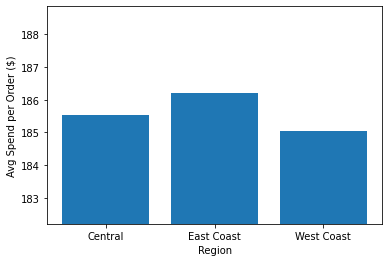

,Region,Sales
1,East Coast,186.19
0,Central,185.54
2,West Coast,185.04


In [43]:
region_spend_df = filtered_sdf.groupby('Region')
avg_region_spend = region_spend_df.mean()['Sales']
regions = [region for region, df in region_spend_df]

plt.bar(regions, avg_region_spend)
plt.ylim(min(avg_state_spend)-1, max(avg_state_spend)+1)
plt.xticks(regions)
plt.xlabel('Region')
plt.ylabel('Avg Spend per Order ($)')
plt.show()

avg_region_spend.reset_index().sort_values('Sales', ascending=False)

##### **What are the Top 5 selling product sold per Region?**


In [44]:
top5 = list(range(1,6))

In [45]:
products_region = filtered_sdf.groupby(['Region','Product'])['Quantity Ordered'].count().reset_index()
products_region['Rank'] = products_region.groupby('Region')['Quantity Ordered'].rank("dense", ascending=False).astype(int)
top_products_region = products_region.loc[products_region['Rank'].isin(top5), :].sort_values(['Region','Quantity Ordered'], ascending=[True,False])

top_products_region

,Region,Product,Quantity Ordered,Rank
12,Central,Lightning Charging Cable,2947,1
15,Central,USB-C Charging Cable,2835,2
4,Central,AA Batteries (4-pack),2764,3
5,Central,AAA Batteries (4-pack),2741,4
17,Central,Wired Headphones,2538,5
34,East Coast,USB-C Charging Cable,7395,1
31,East Coast,Lightning Charging Cable,7194,2
24,East Coast,AAA Batteries (4-pack),6909,3
23,East Coast,AA Batteries (4-pack),6844,4
36,East Coast,Wired Headphones,6210,5


##### **What products generated the most revenue per Region? (Top 5)**

In [46]:
ps_region = filtered_sdf.groupby(['Region','Product'])['Sales'].sum().reset_index()
ps_region['Rank'] = ps_region.groupby('Region')['Sales'].rank("dense", ascending=False).astype(int)
tps_region = ps_region.loc[ps_region['Rank'].isin(top5), :].sort_values(['Region','Sales'], ascending=[True,False])

tps_region

,Region,Product,Sales,Rank
13,Central,Macbook Pro Laptop,1076100.00,1
18,Central,iPhone,627200.00,2
14,Central,ThinkPad Laptop,554994.45,3
9,Central,Google Phone,441000.00,4
3,Central,34in Ultrawide Monitor,319191.60,5
32,East Coast,Macbook Pro Laptop,2682600.00,1
37,East Coast,iPhone,1579900.00,2
33,East Coast,ThinkPad Laptop,1416985.83,3
28,East Coast,Google Phone,1127400.00,4
20,East Coast,27in 4K Gaming Monitor,817029.05,5
